# Sparse Bayes Model

Let's model the data as arising from a generative model in which the log firing rates factorize.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

## Exploratory analysis

In [2]:
dat = pd.read_csv('data/prepared_data.csv')

In [3]:
dat.shape

(687276, 9)

In [4]:
dat.head(10)

,is_first,is_rewarded,stim,unit,run,baseline,count,time,trial
0,0,0,0,1068,0,4,3,0,99889
1,0,0,0,1069,0,1,1,0,101455
2,0,0,0,1070,0,2,4,0,103021
3,0,0,0,1071,0,0,0,0,104587
4,1,0,0,1072,0,0,2,0,106028
5,1,0,0,1073,0,0,1,0,106893
6,1,0,0,1074,0,0,2,0,107758
7,0,0,0,1075,0,0,2,0,108708
8,0,0,0,1076,0,0,1,0,109838
9,0,0,0,1077,0,0,1,0,110980


# Subset data?

In [5]:
subset = False

if subset:
    sdat = dat[(dat.unit < 1100) & (dat.stim < 200)]
else:
    sdat = dat.copy()

In [6]:
mean_count = sdat.groupby(['stim', 'unit'])['count'].mean().unstack()
mean_count.head()

unit,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,5249,5250,5251,5252,5253,5254,5255,5256,5257,5258
stim,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.333333,0.000000,0.000000,0.333333,0.0,1.0,4.0,1.000000,2.000000,1.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.500000,0.333333,1.666667,0.333333,1.0,0.0,1.0,0.333333,1.000000,1.333333
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.750000,0.000000,0.500000,0.500000,0.0,0.0,1.0,3.500000,2.250000,3.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.000000,1.000000,0.333333,0.5,0.0,1.5,0.666667,1.333333,2.666667
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.200000,0.333333,0.333333,1.000000,0.0,2.0,2.0,1.000000,2.333333,3.000000


<IPython.core.display.Javascript object>


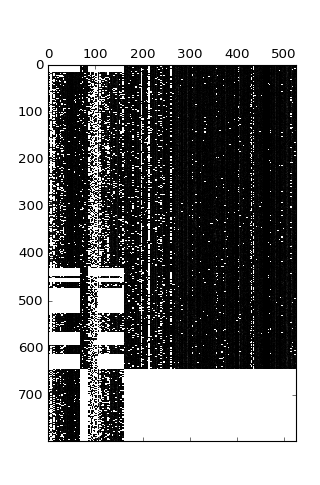

In [7]:
plt.matshow(mean_count, 'aspect=auto', cmap='gray')

In [8]:
S, U = mean_count.shape
N, _ = sdat.shape
print("stims: {}, units: {}, observations: {}".format(S, U, N))

stims: 798, units: 526, observations: 687276


# Set up Stan

In [9]:
import pystan
import pickle

In [10]:
K = 35  # number of possible features
unit = np.unique(sdat.unit.values, return_inverse=True)[1] + 1
stim = np.unique(sdat.stim.values, return_inverse=True)[1] + 1
spk_dat = ({'count': sdat['count'], 'unit': unit, 
            'stim': stim, 'baseline': sdat['baseline'],
            'U': U, 'S': S, 'N': N, 'K': K,
            'Tpre': 0.3, 'Tpost': 0.4,  # epoch durations for spike counts
           })

In [11]:
# for factor_hs.stan
def make_init_fun(U, S, K):
    # returns function that returns inits for model parameters
    # needed because Cauchy dists result in huge outliers
    return lambda: ({'b': 1 + 0.1 * np.random.randn(U),
                     'W_raw': np.abs(np.random.randn(S, K))/K,
                     'V_raw': np.random.randn(U, K)/K,
                     'phi_W': 1 + 0.01 * np.random.randn(S, K),
                     'phi_V': 1 + 0.01 * np.random.randn(U, K),
                     'delta_W': 0.8 + 0.01 * np.random.randn(K),
                     'delta_V': 0.8 + 0.01 * np.random.randn(K),
                     'phi': 0.1 * np.abs(np.random.randn(U)) + 0.1
                    })

In [12]:
load_result = False

In [13]:
if not load_result:
    sm = pystan.StanModel(file='factor_hs.stan')

## To do:
- ~~Negative binomial?~~
- Double Pareto Shrinkage prior? (Expandable Factor Analysis)
- ~~normalize W cols to L2 instead of L1?~~

In [14]:
%%time
if not load_result:
    opt = sm.optimizing(data=spk_dat,
                        seed=12345,
                        iter=100000,
                        init=make_init_fun(U, S, K))

CPU times: user 1h 53min 22s, sys: 3min 13s, total: 1h 56min 36s
Wall time: 1h 56min 38s


In [15]:
if not load_result:
    fname = 'opt_values'
    with open('data/' + fname + '.stan_model', 'wb') as f:
        pickle.dump(opt, f)
else:
    fname = 'opt_values'
    with open('data/' + fname + '.stan_model', 'rb') as f:
        opt = pickle.load(f)    

In [16]:
fname = 'opt_values'
with open('data/' + fname + '.stan_model', 'rb') as f:
    opt = pickle.load(f)

<IPython.core.display.Javascript object>


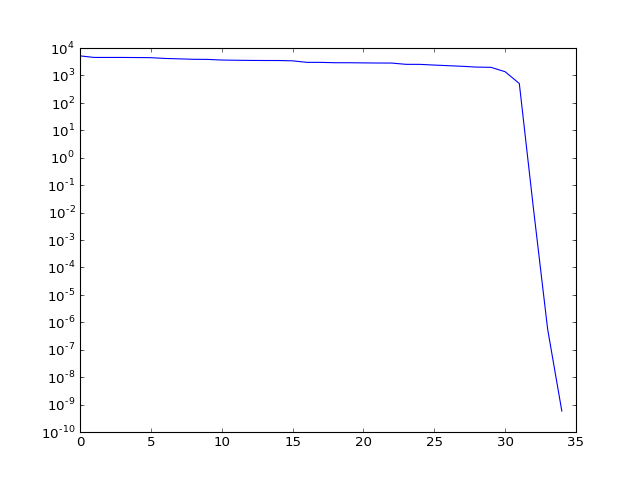

In [17]:
# singular values
W_n = np.apply_along_axis(lambda x: np.linalg.norm(x, 2), 0, opt['W'])
V_n = np.apply_along_axis(lambda x: np.linalg.norm(x, 2), 0, opt['V'])

plt.figure()
svals = W_n * V_n
idx_ord = np.argsort(svals)[::-1]  # sort descending
plt.plot(svals[idx_ord])
plt.gca().set_yscale('log')

<IPython.core.display.Javascript object>


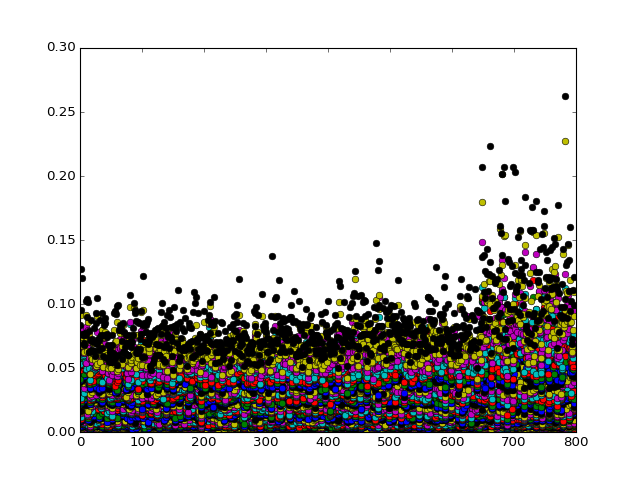

In [18]:
WW = (opt['W']/W_n)[:, idx_ord]
plt.figure()
plt.plot(np.sort(WW), 'o');

<IPython.core.display.Javascript object>


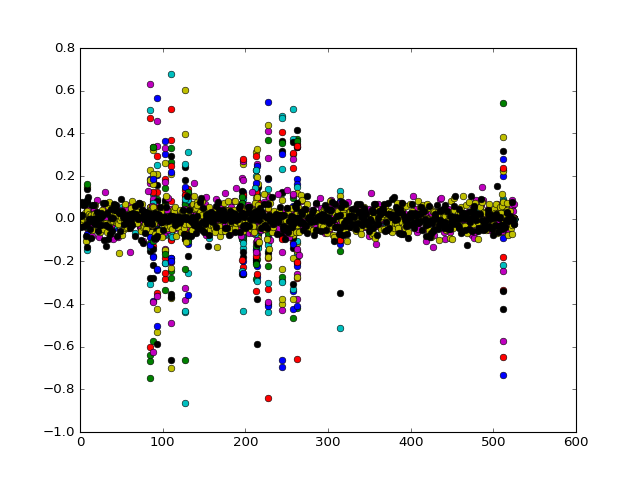

In [19]:
VV = (opt['V']/V_n)[:, idx_ord]

plt.figure()
plt.plot(VV, 'o');

In [20]:
opt['tau_W'], opt['tau_V']

(array([  1.22290595e+02,   1.43363081e+02,   1.49804082e+02,
          1.69371861e+02,   1.67157741e+02,   1.61884070e+02,
          1.91143543e+02,   1.59784164e+02,   1.61805691e+02,
          1.36195777e+02,   1.51111363e+02,   1.34771449e+02,
          1.62667353e+02,   1.80048197e+02,   1.73691872e+02,
          1.59385204e+02,   1.50895683e+02,   1.47059142e+02,
          1.70139837e+02,   1.65820146e+02,   1.70742158e+02,
          1.57152177e+02,   1.71230303e+02,   1.52240319e+02,
          1.49807313e+02,   1.42003113e+02,   1.18198849e+02,
          1.02276809e+02,   1.13893175e+02,   6.62047212e+01,
          9.85789482e+01,   3.19408721e+01,   1.09123021e+00,
          3.53069398e-02,   1.14549606e-03]),
 array([  1.23781065e+02,   1.44237256e+02,   1.52524688e+02,
          1.76265577e+02,   1.73817670e+02,   1.66744931e+02,
          1.93079474e+02,   1.61463708e+02,   1.60105967e+02,
          1.37023988e+02,   1.50922356e+02,   1.34028374e+02,
          1.62631574e+02

# Compare with image attributes

In [21]:
iminfo = pd.read_csv('data/iminfo798.csv').set_index('code')
iminfo.tail()

,image,monkey_name,Human?,Monkey face?,Object?,Perinea?,direct gaze?,averted gaze?,face oriented L,face oriented R,...,Male Perinea?,Female Perinea?,Cayo,Colony,head visible,tail visible,num legs,side view,frontal view,partially occuded
code,,,,,,,,,,,,,,,,,,,,,
1107,lum_tulip01.jpg,NaN,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1108,lum_tupperware05.jpg,NaN,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1109,lum_tweezers02b.jpg,NaN,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1110,lum_umbrella02a.jpg,NaN,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1111,lum_yarn.jpg,NaN,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
iminfo.columns

Index(['image', 'monkey_name', 'Human?', 'Monkey face?', 'Object?', 'Perinea?',
       'direct gaze?', 'averted gaze?', 'face oriented L', 'face oriented R',
       'face straight', 'threat?', 'scrambled?', 'Male Perinea?',
       'Female Perinea?', 'Cayo', 'Colony', 'head visible', 'tail visible',
       'num legs', 'side view', 'frontal view', 'partially occuded'],
      dtype='object')

In [23]:
Wopt = pd.DataFrame(WW, index=np.unique(sdat.stim))
Wopt.index.name = 'code'
Wopt.columns = ['K' + str(c) for c in Wopt.columns]
Wopt = Wopt.reset_index()

iminfo_aug = iminfo.reset_index().merge(Wopt)

In [28]:
feat = 'K' + str(2)
iminfo_aug[['image', feat]].sort_values(by=feat, ascending=False)

,image,K2
766,lum_sherry19_white.jpg,0.146651
752,lum_sherry05_white.jpg,0.121082
695,lum_scr_peri16_white.jpg,0.115851
482,lum_scr_avertedthreat006.jpg,0.106795
684,lum_scr_mm0904_1101_00f.jpg,0.105314
458,lum_scr_averted013.jpg,0.102941
460,lum_scr_averted016.jpg,0.102623
210,lum_mf0909_1100_90l.jpg,0.101431
767,lum_sherry20_white.jpg,0.100451
483,lum_scr_balloon.jpg,0.099336


In [25]:
chunks = []
for kk in range(K):
    for col in iminfo.columns[2:]:
        kcol = 'K' + str(kk)
        weighted_mean = np.average(iminfo_aug[col], weights=iminfo_aug[kcol])
        nat_mean = np.average(iminfo_aug[col])
        chunks.append({
                'content': col,
                'feature': kk,
                'natural': nat_mean,
                'weighted': weighted_mean,
                'ratio': weighted_mean/nat_mean,
                'change': weighted_mean/nat_mean - 1
            })
overlap = pd.DataFrame(chunks).sort_values(by=['feature', 'change'])

In [26]:
overlap.query('feature == 0')

,change,content,feature,natural,ratio,weighted
18,-0.231019,side view,0,0.026316,0.768981,0.020236
7,-0.207928,face oriented R,0,0.112782,0.792072,0.089331
17,-0.196383,num legs,0,0.184211,0.803617,0.148035
16,-0.188520,tail visible,0,0.078947,0.811480,0.064064
4,-0.168083,direct gaze?,0,0.122807,0.831917,0.102165
6,-0.149330,face oriented L,0,0.126566,0.850670,0.107666
19,-0.143380,frontal view,0,0.067669,0.856620,0.057967
13,-0.129597,Cayo,0,0.165414,0.870403,0.143976
5,-0.126028,averted gaze?,0,0.250627,0.873972,0.219041
1,-0.108610,Monkey face?,0,0.417293,0.891390,0.371971


# Now sample from optimum

In [18]:
def make_sample_init_fun(U, S, K):
    # returns function that returns inits for model parameters
    # needed because Cauchy dists result in huge outliers
    return lambda: ({'b': opt['b'] * (1 + 0.01 * np.random.randn(U)),
                     'W_raw': opt['W_raw'] * (1 + 0.01 * np.random.randn(S, K)),
                     'V_raw': opt['V_raw'] * (1 + 0.01 * np.random.randn(U, K)),
                     'phi_W': opt['phi_W'] * (1 + 0.01 * np.random.randn(S, K)),
                     'phi_V': opt['phi_V'] * (1 + 0.01 * np.random.randn(U, K)),
                     'delta_W': opt['delta_W'] * (1 + 0.01 * np.random.randn(K)),
                     'delta_V': opt['delta_V'] * (1 + 0.01 * np.random.randn(K)),
                    })

In [19]:
%%time
fit = sm.sampling(data=spk_dat, iter=2000, thin=10, chains=4,
                  seed=12345,
                  pars=['W', 'V', 'b'],
                  init=make_sample_init_fun(U, S, K))

Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/Users/jmxp/anaconda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/jmxp/anaconda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/jmxp/anaconda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/jmxp/anaconda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/jmxp/anaconda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jmxp/anaconda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jmxp/anaconda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jmxp/anaconda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jmxp/

In [ ]:
def get_summ_df(fit, var):
    summ = fit.summary(var)
    return pd.DataFrame(summ['summary'], index=summ['summary_rownames'], columns=summ['summary_colnames'])

In [ ]:
W = get_summ_df(fit, 'W')

In [ ]:
W

In [ ]:
def plot_coeffs(df, sorted=False, transform=None):
    fig = plt.figure()
    if transform:
        b_m = transform(df['mean'])
        b_lo = b_m - transform(df['2.5%'])
        b_hi = transform(df['97.5%']) - b_m
    else:
        b_m = df['mean']
        b_lo = b_m - df['2.5%']
        b_hi = df['97.5%'] - b_m

    if len(b_m) > 1:
        if sorted:
            idx = np.argsort(b_m)
        else:
            idx = np.arange(len(b_m))

        b_m, b_lo, b_hi = b_m[idx], b_lo[idx], b_hi[idx]

        contains_1 = (df['2.5%'][idx] < 0) & (df['97.5%'][idx] > 0)
        
    else:
        contains_1 = (df['2.5%'] < 0) & (df['97.5%'] > 0)
    
    plt.errorbar(np.arange(len(b_m)), b_m, yerr=[b_lo, b_hi], capthick=0, 
                 marker='o', linestyle='None')

    # plot "significant" coefficients in red
    
    sigs = np.where(~contains_1)[0]
    plt.errorbar(sigs, b_m[sigs], yerr=[b_lo[sigs], b_hi[sigs]], capthick=0, 
                 marker='o', linestyle='None', color='red')

    if transform:
        plt.axhline(transform(0), color='k', zorder=-1)
    else:
        plt.axhline(0, color='k', zorder=-1)
            
    plt.xlim(-1, len(b_m) + 1)
    
    return fig

In [ ]:
plot_coeffs(W, sorted=True);
plt.ylim(-10, 10)

In [ ]:
wt = fit.extract('W', permuted=False)
plt.figure()
plt.plot(wt[:, 1:10, 0]);

In [ ]:
wt = fit.extract('W', permuted=False)
wt.shape

In [ ]:
V = get_summ_df(fit, 'V')
V

In [ ]:
plot_coeffs(V, sorted=True);
plt.ylim(-10, 10)

In [ ]:
baseline = get_summ_df(fit, 'b')
baseline

In [ ]:
plot_coeffs(baseline, sorted=True);